<a href="https://colab.research.google.com/github/spienaar13/Assignment5/blob/main/HomeWork3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification of Protein Sequences via LSTMs and TCNs with Skip Connections**

Due 11:59pm on October 30th 2023

Proteins are large, complex bio-molecules responsible for carrying out multiple critical bodily functions.  They are composed of chains (long variable-order sequences with repeats) of 20 possible amino acids.  The constituent amino acids that make up a protein determine its unique structure as well as function.  In this assignment, we will use deep learning and a protein database called 'Pfam' to classify amino acid sequences into their protein families.

In [ ]:
#1. First download the dataset from here: https://www.kaggle.com/googleai/pfam-seed-random-split
#2. Upload the data folder from #1 to your Google Drive
#MOUNTING GOOGLE DRIVE WHERE DATA IS STORED
from google.colab import drive
drive.mount('/gdrive', force_remount=True)


Mounted at /gdrive


In [ ]:
#Required Imports
%matplotlib inline
!pip install einops
!pip install Levenshtein

import gc
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import itertools
import random
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from Levenshtein import distance as levenshtein_distance

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.4 MB/s eta 0:00:00


In [ ]:
# Reading in the Pfam dataset
# data is randomly split into three folders [train(80%), test(10%), dev(10%)]
# reading and concatenating data for each folder.
# Import data and save as np.array

data_path = '/gdrive/MyDrive/Academics/BMEN4470/HW3dataset/random_split/'
print('Available data', os.listdir(data_path))

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

# reading all data_partitions and visualizing (head) of the data
df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')
df_train.head()

Available data ['dev', 'train', 'random_split', 'test']


,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,MORN_2,Q8EI47_SHEON/428-449,PF07661.13,LHGEFRNQTSSGQLLELI.NFNH,LHGEFRNQTSSGQLLELINFNH
1,Plexin_cytopl,H2TB23_TAKRU/1240-1793,PF08337.12,.MPFLDYKTYTDCNFFLPSKDGAND......AMITRKLQIPE.......,MPFLDYKTYTDCNFFLPSKDGANDAMITRKLQIPEARRAIVAQALN...
2,RT_RNaseH,H3H8E9_PHYRM/405-501,PF17917.1,DYSRRFHVFADAS.GH.QIGGVIVQ........................,DYSRRFHVFADASGHQIGGVIVQGRRILACFSRSMTDTQKKYSTME...
3,Transposase_20,Q981X5_RHILO/224-313,PF02371.16,VEAYQAMRGASFLVAVIFAAEI.GDV.RR.FDTPPQLMAFLGLVPG...,VEAYQAMRGASFLVAVIFAAEIGDVRRFDTPPQLMAFLGLVPGERS...
4,Mycobact_memb,MMPS4_MYCLE/16-154,PF05423.13,LSRIWIPLVILVVLVVGGFVVYRVHSYFASEKRESYADSNLGSSKP...,LSRIWIPLVILVVLVVGGFVVYRVHSYFASEKRESYADSNLGSSKP...


# Overview of Data Components:

*sequence:* This is the input to the model, an amino acid sequence for a protein. There are 20 common amino acids (frequency > 1,000,000), and 4 amino acids that are uncommon: U, B, O, Z, and X stands for an unknown or generic/'wild-card' amino acid.

*family_accession:* These are the labels (outputs) of the model. Accession number is in the form PFxxxxx.y, where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.

*sequence_name:* Sequence name, in the form "uniprot_accession_id/start_index-end_index".

*aligned_sequence:* The aligned version of the *sequence* (above) with gaps retained.

*family_id:* One word name for protein family.


**Getting Familiar with the Data:** the following few cells will help you get familiar with the data, an important step to allow you to build your deep learning sequence model

In [ ]:
# An example unaligned sequence, input to the model
# Each character represents one of the 25 (20 common + 4 uncommon + 1 'wild-card')
# amino acids in the sequence.

df_train.head(1)['sequence'].values[0]

'LHGEFRNQTSSGQLLELINFNH'

In [ ]:
# Given data size (number of sequences in each set)
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  1086741
Val size:  126171
Test size:  126171


In [ ]:
#Getting a sense of the data: number of families/classes
def calc_unique_cls(train, test, val):
  """
  Prints # unique classes in data sets.
  """
  train_unq = np.unique(train['family_accession'].values)
  val_unq = np.unique(val['family_accession'].values)
  test_unq = np.unique(test['family_accession'].values)

  print('Number of unique classes in Train: ', len(train_unq))
  print('Number of unique classes in Val: ', len(val_unq))
  print('Number of unique classes in Test: ', len(test_unq))

# Unique classes in the given dataset : [df_train, df_val and df_test]
calc_unique_cls(df_train, df_test, df_val)

Number of unique classes in Train:  17929
Number of unique classes in Val:  13071
Number of unique classes in Test:  13071


**Problem 1a:** Use the code in the following cell to plot the typical lengths of sequences in this dataset.  What is the the approximate most prevalent/common sequence length?  You will use this later for pre-processing your sequences.

Most common sequence length in Train :  69
Occurs  8860  times
Most common sequence length in Val :  69
Occurs  1074  times
Most common sequence length in Test :  69
Occurs  1069  times


<ipython-input-5-b9ee28d95a66>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['seq_char_count'].values)
<ipython-input-5-b9ee28d95a66>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['seq_char_count'].values)
<ipython-input-5-b9ee28d95a66>:21: UserWarning: 

`distplot` is a deprecated

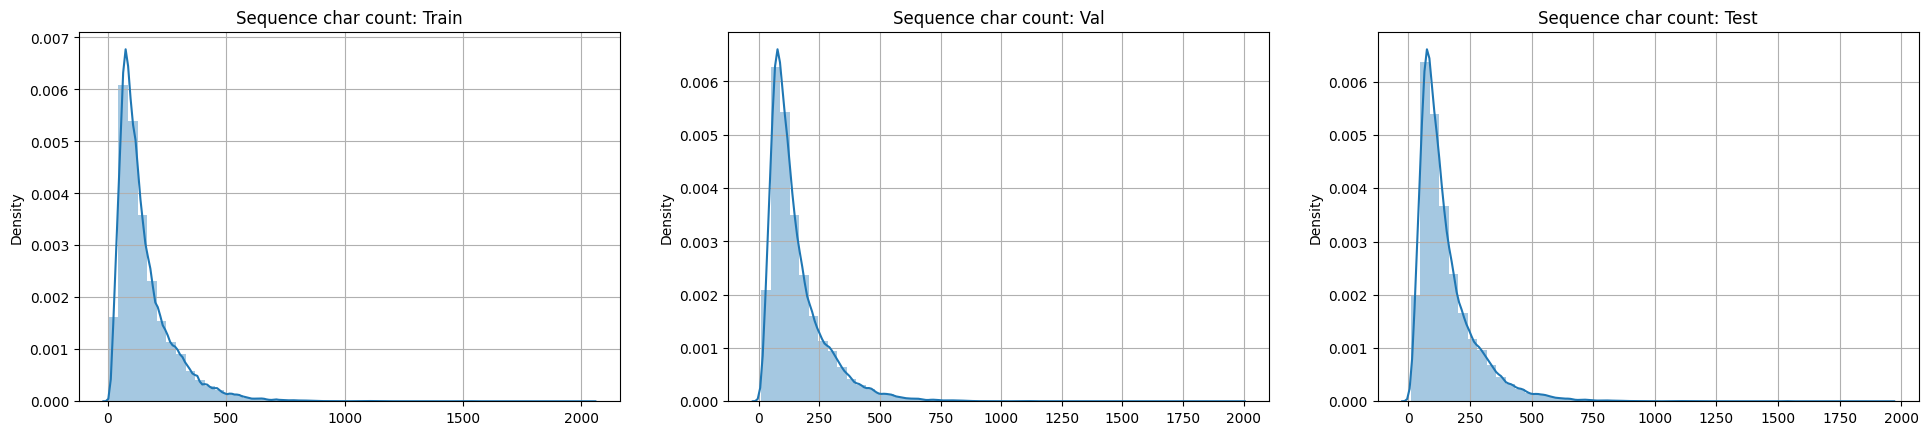

In [ ]:
# The code below will allow you to plot the typical lengths of
# amino acid sequences for train, val, and test datasets.

df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

# Function that prints the most common sequence length of a given dataset/subseg
def most_common(df, data_name):
  train_unq, counts = np.unique(df['seq_char_count'].values, return_counts=True)
  index = np.argmax(counts)
  print('Most common sequence length in', data_name, ': ', train_unq[index])
  print('Occurs ', counts[index], ' times')
  return

most_common(df_train, 'Train')
most_common(df_val, 'Val')
most_common(df_test, 'Test')

def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)


plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()


**Answer:**

Each part of the dataset has a very similar distribution of sequence length, whose density is highest at roughly ~100 amino acids. Further inspection, see above most_common function, reveals this number to be exactly 69 amino acid length sequence.

Amino acids are represented in a protein sequence with their corresponding 1 letter code; for example, the code for alanine is (A), arginine is (R), and so on. The complete list of amino acid codes is [here](https://www.ddbj.nig.ac.jp/ddbj/code-e.html) under 'Amino Acid Codes'.

In [ ]:
#Determine the number of instances of each amino acid code across all sequences
#in train, val, and test sets
def get_code_freq(df, data_name):

  df = df.apply(lambda x: " ".join(x))

  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space

  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')

# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')

# test code sequence
test_code_freq = get_code_freq(df_test['sequence'], 'Test')

def plot_code_freq(df, data_name):

  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

Codes: Train
Total unique codes: 25
Codes: Val
Total unique codes: 22
Codes: Test
Total unique codes: 24


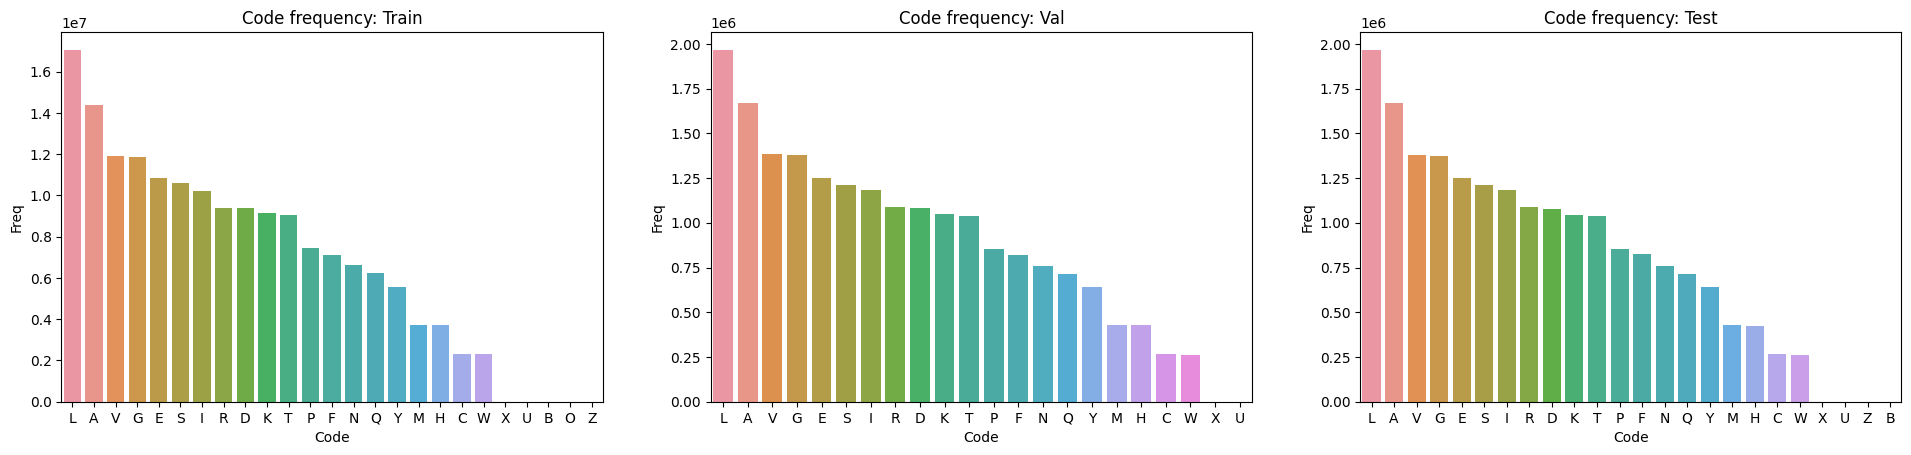

In [ ]:
#Plot the Amino Acid Code frequency for this dataset
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [ ]:
# Since our dataset is large, we will consider only the top 300 most-observed
# protein classes/families due to limited computational power.

classes = df_train['family_accession'].value_counts()[:300].index.tolist()
len(classes)

# Filtering data based on considered 300 classes.
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 300 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

# No. of unique classes after reducing the data size.
calc_unique_cls(train_sm, test_sm, val_sm)

Data size after considering 300 classes for each data split:
Train size : 210358
Val size : 26129
Test size : 26129
Number of unique classes in Train:  300
Number of unique classes in Val:  300
Number of unique classes in Test:  300


Here we start developing our **Deep Learning** model.  First task is to preprocess the amino acid sequences in our dataset.

In [ ]:
# The code below creates our amino acid code sequence dictionary
# https://dmnfarrell.github.io/bioinformatics/mhclearning
# 1 letter code for 20 natural amino acids

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [ ]:
#Now we will encode our sequences made of letters into sequences of integers
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids (and X 'wild-card') are taken into consideration.
    Remaining 4 uncommon amino acids are categorized as 0 (so not included).
  """

  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))

  return encode_list

train_encode = integer_encoding(train_sm)
val_encode = integer_encoding(val_sm)
test_encode = integer_encoding(test_sm)

#Just to visualize an example of the output
print(train_encode[0])

[ 3  7 10 18  4 10 15 17 15 10 10 19  2  5 18  1  8 10  1  6 17 18  5  2
 20 18  5 18 14  3  8 20  6  5 10 18 15 13 10  1  3  1 11  6 13  6  3 16
 14 15 10  8 20 17 12 10 17  4  1  5  5 17 20 10  9  8  1  5 19  6  6  1
  5 10 17  5 13 18 10  1 18 14  8 19  6  5  8  1 13  6 10 20  6  9  4 15
  9  1  5 10 13 20 10 18  1 17 13 18 10  5  8 17  6  1  1 10 18 20 20 10
  8 11 13 11  1 19 15  5  5 10  6  5 14 16 17  6  1  4 17  1 10 13  8 14
 10  4  1 15 18 16  4 20 10  3 10 18 11 18 10 11  5  1  5  6  5  2  5 14
 10 13 18 10 10 16 10 11  1 15  1  6 11  8 17  3  1 18 10 18 15  6 15 15
 20  1  8 18 10  8  5 18 18  1  1 18  8 17 13 13  3 18  8 16 14  8  6 10
  1  8 13]


In [ ]:
# The code to encode labels/output variable y (amino acid family/class) into integers
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((210358,), (26129,), (26129,))

**Problem 1b:** Now we must ensure all sequences are the same length since our sequence model can only take in fixed-size inputs.  Pad the sequences using Keras *pad_sequences* [function](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences), using the max_length you determined in part (a).  Use 'post' padding to pad with 0 if the total sequence length is less than max_length or truncate the sequence (if longer) to max_length.

In [ ]:
# Your code below for padding sequences
max_length = 69

train_encode_pad = pad_sequences(
    train_encode,
    maxlen=max_length,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0)

val_encode_pad = pad_sequences(
    val_encode,
    maxlen=max_length,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0)

test_encode_pad = pad_sequences(
    test_encode,
    maxlen=max_length,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0)


**Problem 1c:** Now encode input sequences and output labels using one-hot encoding (zeros everywhere except for at location of the appropriate amino acid code) using Keras *to_categorical* function.

In [ ]:
# Your code here: One hot encoding of sequences
x_train_OHencode = to_categorical(train_encode_pad)
x_val_OHencode = to_categorical(val_encode_pad)
x_test_OHencode = to_categorical(test_encode_pad)
x_train_OHencode.shape

(210358, 69, 21)

In [ ]:
# Your code here: One hot encoding of outputs
y_train_final = to_categorical(y_train_le)
y_val_final = to_categorical(y_val_le)
y_test_final = to_categorical(y_test_le)
y_train_final.shape

(210358, 300)

In [ ]:
#Utility functions: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)

  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

**Problem 1d:** Implement code here for a [bidirectional LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) using Keras Functional or Sequential API.  Unlike RNNs which only take input from the previous timestep, LSTMs can remember information from the distant past via gating mechanisms.  Bidirectional LSTMs can incorporate contextual information from both past and future, improving their performance even more compared to unidirectional LSTMs on sequential data.

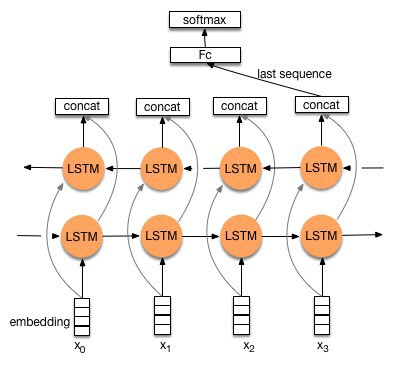

In [ ]:
# Implement your code here:
# Hint: use an embedding layer to project your sequence data to a higher dimension,
# and use the diagram above for some ideas on layers to include in your model.
# Remember to compile your model after designing it.
x_input = Input((max_length, ))

# Embedding layer
emb = Embedding(21, 128, input_length=max_length)(x_input)
# TWO bidirectional LSTMs with 64 and 128 units
bi_rnn1 = Bidirectional(LSTM(64, return_sequences=True))(emb)
bi_rnn2 = Bidirectional(LSTM(128, return_sequences=False))(bi_rnn1)
# Dropout Layer
x = Dropout(0.02)(bi_rnn2)

# Softmax classifier
x_output = Dense(300, activation='softmax')(x)

#Compiling with adam and categorical crossentropy
model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'val_loss'])
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 69)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 69, 128)           2688      
                                                                 
 bidirectional_4 (Bidirecti  (None, 69, 128)           98816     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               7710

**Problem 1e:** Now train your model using Keras model.fit function. Add the given early stopping as a parameter to your fit function to prevent overtraining.  Use at least 10 epochs (it will take 15-20min to train with GPU: Remember turn GPU on by going to Runtime --> Change Runtime Type --> GPU) and a batch size of 256.  Validate on your padded validation sequences from above.

In [ ]:
# Train your model using Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

import gc
try:
  del df_train
  del df_val
  del df_test
  gc.collect()
except:
  pass

history1 = model1.fit(
    train_encode_pad, y_train_final,
    epochs=30, batch_size=256,
    validation_data=(val_encode_pad, y_val_final),
    callbacks=[es]
    )


Epoch 1/40
822/822 [==============================] - 39s 31ms/step - loss: 2.1743 - accuracy: 0.5301 - val_loss: 0.6958 - val_accuracy: 0.8390
Epoch 2/40
822/822 [==============================] - 24s 29ms/step - loss: 0.4301 - accuracy: 0.9010 - val_loss: 0.2702 - val_accuracy: 0.9382
Epoch 3/40
822/822 [==============================] - 24s 29ms/step - loss: 0.2020 - accuracy: 0.9533 - val_loss: 0.1714 - val_accuracy: 0.9591
Epoch 4/40
822/822 [==============================] - 24s 29ms/step - loss: 0.1209 - accuracy: 0.9724 - val_loss: 0.1208 - val_accuracy: 0.9701
Epoch 5/40
822/822 [==============================] - 24s 29ms/step - loss: 0.0812 - accuracy: 0.9812 - val_loss: 0.0946 - val_accuracy: 0.9769
Epoch 6/40
822/822 [==============================] - 24s 29ms/step - loss: 0.0562 - accuracy: 0.9875 - val_loss: 0.0838 - val_accuracy: 0.9785
Epoch 7/40
822/822 [==============================] - 24s 29ms/step - loss: 0.0411 - accuracy: 0.9911 - val_loss: 0.0758 - val_accuracy:

Exception ignored in: <function _xla_gc_callback at 0x78c8878b5360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


822/822 [==============================] - 11s 13ms/step - loss: 0.0041 - accuracy: 0.9992
Train loss:  0.004079774022102356
Train accuracy:  0.9992156028747559
----------------------------------------------------------------------
103/103 [==============================] - 1s 14ms/step - loss: 0.0458 - accuracy: 0.9886
Val loss:  0.045824166387319565
Val accuracy:  0.9885568022727966
----------------------------------------------------------------------
103/103 [==============================] - 1s 14ms/step - loss: 0.0472 - accuracy: 0.9878
Test loss:  0.047212883830070496
Test accuracy:  0.9877913594245911


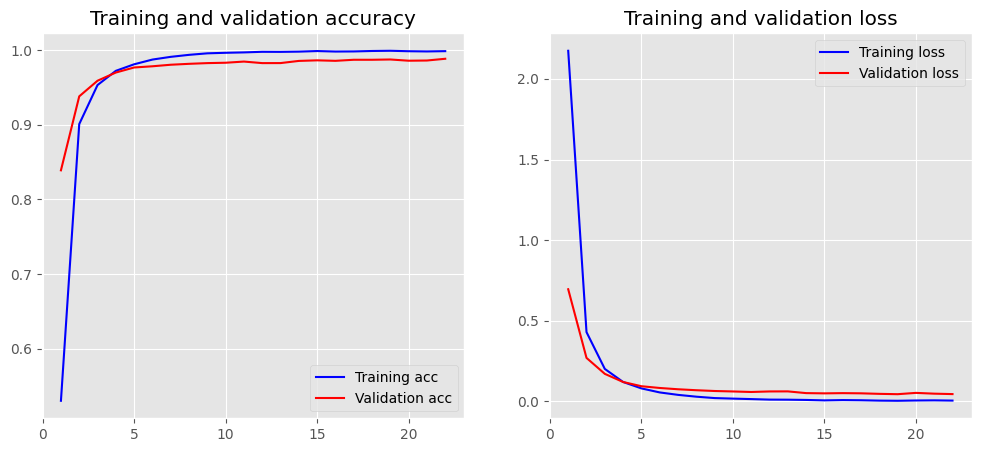

In [ ]:
# Show your model results and plots
display_model_score(model1,
    [train_encode_pad, y_train_final],
    [val_encode_pad, y_val_final],
    [test_encode_pad, y_test_final],
    256)

plot_history(history1)

In [ ]:
#Save your model in case you need to run again to save time with training
model1.save_weights('/gdrive/MyDrive/Academics/BMEN4470/HW3dataset/Model_ValAc0.9886.h5')

**Problem #2a**: In this problem, we will assess the interclass variability of embeddings. We will plot t-SNE clusters within and between family_accession samples.  

Extract the weights from the embedding layer of your model1. The shape of your weight matrix should make sense - it should be (sequence_length x embedding_dim)

In [ ]:
embedding_weights =  np.array(model1.get_layer('embedding_2').get_weights())

Within 5 classes, compute the embeddings for each sample in your validation set, storing them as you go to a new data matrix (X).

In [ ]:
from einops import rearrange
num_classes = 5 # number of classes we will store average distances for

X = None
y = None
for class_of_interest in classes[:num_classes]:
  # e.g. class_of_interest == 'PF01967.21'
  class_indices = list(val_sm.loc[val_sm.family_accession==class_of_interest].index)

  all_class_samples = np.dot(x_val_OHencode[class_indices],embedding_weights.squeeze())

  # this rearranges to samples x features shape by flattening time and embedding shapes
  all_class_samples = rearrange(all_class_samples,'s t e -> s (t e)')
  if X is None:
    X = all_class_samples
    y = np.array([class_of_interest] * len(class_indices))
  else:
    X = np.concatenate((X, all_class_samples))
    y = np.concatenate((y, np.array([class_of_interest] * len(class_indices))))

**Problem #2b**: Use t-SNE to fit and transform your X matrix to 2 components for visualization.

*Answer the following questions from your plot*:

What do you notice about the clusters? Why does this result occur and how does it help the LSTM model better learn to classify protein function?

In [ ]:
from sklearn.manifold import TSNE
# Your t-SNE code here
tsne_model = TSNE(n_components=2, random_state=0)
tsne_results = tsne_model.fit_transform(X)

<Axes: xlabel='tsne-dim1', ylabel='tsne-dim2'>

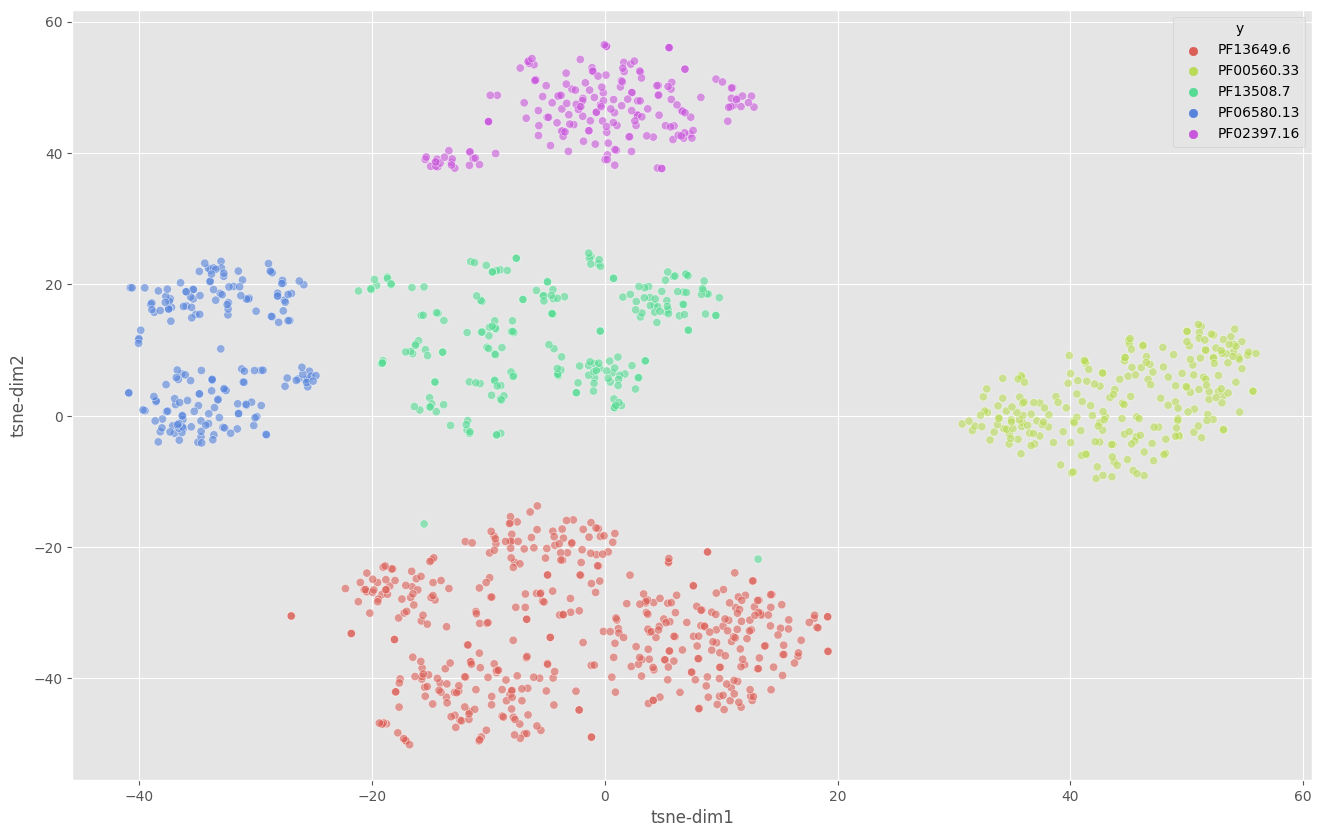

In [ ]:
import seaborn as sns

# this should plot your lower-dimensional representations of samples, colored by family_accession
tsne_df = pd.DataFrame()
tsne_df['y'] = y
tsne_df['tsne-dim1'] = tsne_results[:,0]
tsne_df['tsne-dim2'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-dim1", y="tsne-dim2",
    hue="y",
    palette=sns.color_palette("hls", num_classes),
    data=tsne_df,
    legend="full",
    alpha=0.6
)

Your answer to the questions here.

Clear variables in case we run into RAM issues with Colab updates

In [ ]:
import gc

try:
  del tsne_results
  del tsne_df
  del embedding_weights
  del model1
  del model2
  del df_train
  del df_val
  del df_test
  del train_encode
  del val_encode
  del test_encode
  del y_train_le
  del y_val_le
  del y_test_le
  del train_encode_pad
  del val_encode_pad
  del test_encode_pad
  gc.collect()
except:
  pass

**Problem #3a:** Now we will repeat the protein sequence classification task of Problem #1  using a ResNet based [temporal (1D) convolution network](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) with dilation.  Use Keras functional API to design two convolutional blocks and then use the Add() [function](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add) to combine your input (data) with the output of your 2nd convolutional block.

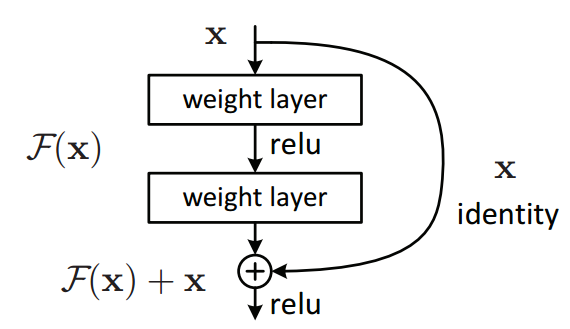

In [ ]:

#Add your code to define a residual block below, as shown in the diagram above
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """
  skipto = data

# First convulational block with batch normilzation to prevent weight decay/expl
  BN1 = BatchNormalization()(data)
  act1 = Activation('relu')(BN1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same')(act1)

# Second convulational block with batch normilzation to prevent weight decay/expl
  BN2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(BN2)
  conv2 = Conv1D(filters, 3, padding='same')(act2)

  #skip connection from conv2 to data
  x = Add()([conv2, skipto])

  return x

**Problem 3b:** Design a simple 1D temporal convolution network around the residual networks (called below using the definition you implemented in part a) with Keras Functional API.  Include an input layer and convolution layer before the residual networks and max pooling, dropout, flatten, and output dense layers after them.  You can refer to this [paper](https://www.biorxiv.org/content/10.1101/626507v4.full) which describes the final architecture in more detail.

In [ ]:
#Insert your code before and after the residual networks called below
#Input
x_input = Input(shape=(max_length, 21))

#Initial convolution
conv = Conv1D(64, 1, padding='same')(x_input) #extract basic information

#Residual blocks added to
res1 = residual_block(conv, 64, 2)
res2 = residual_block(res1, 64, 4)

#Max Pooling with dropout for decreased comp. costs
x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

#Softmax classification for final dense layer
x = Flatten()(x)
x_output = Dense(300, activation='softmax')(x)

#Compiling with adam and categorical crossentropy
model2 = Model(inputs=x_input, outputs=x_output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', run_eagerly=True, metrics=['accuracy', 'val_loss'])
model2.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 69, 21)]             0         []                            
                                                                                                  
 conv1d_5 (Conv1D)           (None, 69, 64)               1408      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 69, 64)               256       ['conv1d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_4 (Activation)   (None, 69, 64)               0         ['batch_normalization_4[

**Problem 3c:** Train your model with early stopping using 10 epochs and a batch size of 256.  Validate with your one-hot-encoded validation data from above.

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

x_train = x_train_OHencode
y_train = y_train_final

history2 = model2.fit(
    x_train, y_train,
    epochs=30, batch_size=256,
    validation_data=(x_val_OHencode, y_val_final),
    callbacks=[es]
    )


Epoch 1/30


TypeError: ignored

In [ ]:
#Plot loss and accuracy and evaluate your model.
plot_history(history2)
display_model_score(
    model2,
    [x_train_OHencode, y_train_final],
    [x_val_OHencode, y_val_final],
    [x_test_OHencode, y_test_final],
    256)

**Problem 3d:** Provide a brief comparison of your two models in a markdown cell.  What were their train, val, and test accuracies?  Which one performed better?  Why do you think this is the case?

Write your answer here...

**What to Submit:** Submit this ipynb with your code and short written responses in markdown cells by **October 30th at 11:59pm**. Please submit a .pdf version of your ipynb and a .ipynb version of your notebook. The pdf version helps us with grading.